# Computer Vision Formative Assessment 1
## Date: 17/09/2024
## Name: Mahima Nair
## PRN : 121B1B161
## B.Tech Computer Engineering Div: C
## Topic: AutoGrade: Automated OMR-based MCQ Grading System


AutoGrade is an Optical Mark Recognition (OMR) system designed to automate the grading of multiple-choice questions (MCQs). Leveraging image processing and Computer Vision techniques, AutoGrade scans OMR sheets, identifies marked responses, and compares them to a predefined answer key to instantly calculate scores. The system improves grading efficiency, eliminates human error, and provides accurate, real-time results for exams. It is highly adaptable for educational institutions and organizations conducting assessments on paper-based formats, significantly reducing time and effort in exam evaluation.

#### Importing necessary libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#### Configuration and Setup

In [2]:
path = "images/input/omr10.png"
widthImg = 700
heightImg = 700
questions = 5
choices = 5
#defining the actual answers with zero-based indexing per question
ans = [1,0,0,1,2]

### Image Preprocessing

In [3]:
img = cv2.imread(path)
img = cv2.resize(img,(widthImg,heightImg))

In [4]:
img.shape

(700, 700, 3)

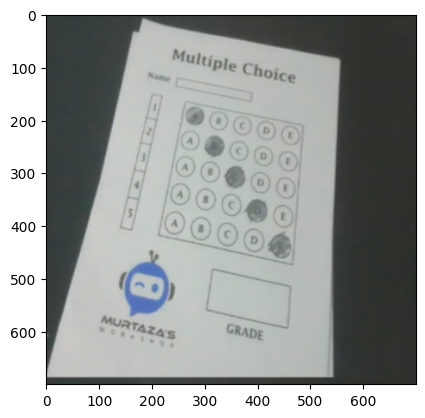

In [5]:
plt.imshow(img)

In [6]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray, (5,5),1)
#Detect edges using canny function
imgCanny = cv2.Canny(imgBlur,10,50)
imgContours = img.copy()  # Copy image for contour visualization
imgKeyContours = img.copy()   # Copy image for biggest contour visualization
imgFinal = img.copy()
imgBlank = np.zeros_like(img)

#### Function to display all the preprocessed image in one frame/stack itself:

In [7]:
## TO STACK ALL THE IMAGES IN ONE WINDOW
def stackImages(imgArray, scale, labels=[]):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range(0,rows):
            for y in range(0,cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0,0), None, scale, scale)
                if len(imgArray[x][y].shape)==2: imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x],(0,0),None,scale,scale)
            if len(imgArray[x].shape)==2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        hor_con = np.concatenate(imgArray)
        ver = hor
    if len(labels) !=0:
        eachImgWidth = int(ver.shape[1]/cols)
        eachImgHeight = int(ver.shape[0]/rows)
        #print(eachImgHeight)
        for d in range(0,rows):
            for c in range(0,cols):
                cv2.rectangle(ver,(c*eachImgWidth,eachImgHeight*d),(c*eachImgWidth+len(labels[d][c])*13+27,30+eachImgHeight*d),(255,255,255),cv2.FILLED)
                cv2.putText(ver,labels[d][c],(eachImgWidth*c+10,eachImgHeight*d+20),cv2.FONT_HERSHEY_COMPLEX,0.7,(255,0,255),2)
    return ver

### Feature Extraction 

### Contour Detection

In [8]:
contours, hierarchy = cv2.findContours(imgCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(imgContours, contours, -1,(0,255,0),10)

array([[[54, 61, 58],
        [54, 61, 58],
        [54, 61, 58],
        ...,
        [50, 51, 48],
        [50, 50, 48],
        [50, 50, 48]],

       [[54, 61, 58],
        [54, 61, 58],
        [54, 61, 58],
        ...,
        [50, 51, 48],
        [50, 50, 48],
        [50, 50, 48]],

       [[55, 60, 57],
        [54, 60, 57],
        [54, 60, 58],
        ...,
        [50, 51, 48],
        [50, 50, 48],
        [50, 50, 48]],

       ...,

       [[57, 59, 55],
        [57, 59, 55],
        [58, 60, 56],
        ...,
        [50, 50, 48],
        [49, 50, 48],
        [49, 50, 48]],

       [[57, 60, 56],
        [57, 60, 56],
        [58, 60, 56],
        ...,
        [50, 51, 48],
        [50, 50, 48],
        [50, 50, 48]],

       [[57, 60, 56],
        [57, 60, 56],
        [58, 60, 56],
        ...,
        [50, 51, 48],
        [50, 50, 48],
        [50, 50, 48]]], dtype=uint8)

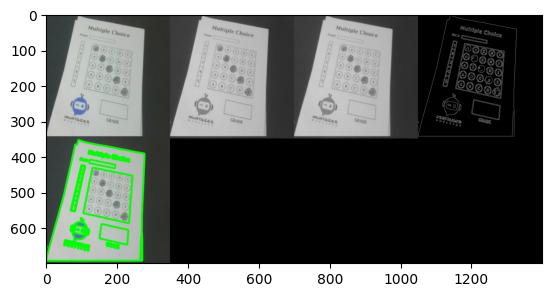

In [9]:
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgBlank,imgBlank,imgBlank])
imgStacked = stackImages(imageArray, 0.5)
plt.imshow(imgStacked)

We need to detect the closed rectangular contours present in the image out of which the biggest contour will be the OMR bubbles box and the 2nd biggest contour will be the grade box

In [10]:
#To detect which of the contours are actually rectangular ROI
def rectContour(contours):
    #1. Small area rectangles should be filtered out
    #2. A rectangle should have 4 corner points
    
    rectCon = []    
    for i in contours:
        area = cv2.contourArea(i)
        #print(area)
        if(area>50):
            peri = cv2.arcLength(i,True)#closed hence true
            approx = cv2.approxPolyDP(i,0.02*peri,True)# to find no. of corner points in the polygon
            #print("Corner points:", len(approx))
            if len(approx)==4:
                rectCon.append(i)
                
    #Sort according to area of rect
    rectCon = sorted(rectCon, key = cv2.contourArea,reverse=True)
    return rectCon
                
    #print(rectCon)
                
            


In [11]:
#find all rectangles
rectCon = rectContour(contours)


In [12]:
biggestContour = rectCon[0]
print(len(biggestContour))

998


In [14]:
biggestContour = getCornerPoints(rectCon[0])  # Get corner points of the largest rectangle (OMR box)
print(biggestContour)

[[[263 165]]

 [[212 419]]

 [[468 474]]

 [[487 210]]]


In [13]:
def getCornerPoints(cont):
    peri = cv2.arcLength(cont,True)#closed hence true
    approx = cv2.approxPolyDP(cont,0.02*peri,True)# to find no. of corner points in the polygon
    return approx
    

In [15]:
gradePoints = getCornerPoints(rectCon[1])  # Get corner points of the largest rectangle (OMR sheet)
print(gradePoints)

[[[313 482]]

 [[303 561]]

 [[458 594]]

 [[462 513]]]


#### Corner Detection and Perspective Warping

In [16]:
if biggestContour.size!=0 and gradePoints.size!=0:
    cv2.drawContours(imgKeyContours, biggestContour, -1, (0,255,0),40)
    cv2.drawContours(imgKeyContours, gradePoints, -1, (0,0,255),40)

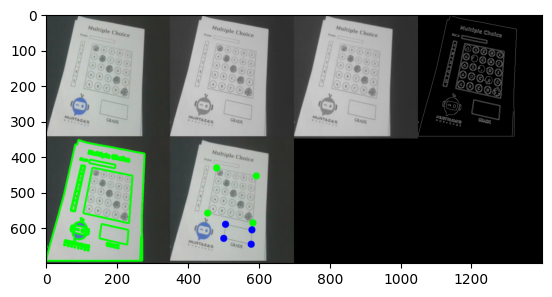

In [17]:
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgBlank,imgBlank])
imgStacked = stackImages(imageArray, 0.5)
plt.imshow(imgStacked)

### Re-ordering the points of the contours before perspective warping

In [18]:
# To find the origin point and porper ordersing of all corner points of the contour
def reorder(myPoints):
    #reshape the points as 4,2(i.e 4 rows of x,y)
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2), np.int32)
    #sum of the row coordinates to find the origin(smallest) point
    add = myPoints.sum(1)
    #print(myPoints)
    print(add)
    myPointsNew[0] = myPoints[np.argmin(add)] #[0,0]-->origin
    myPointsNew[3] = myPoints[np.argmax(add)] #[w,h]-->corner point
    diff = np.diff(myPoints,axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)] # [w,0]
    myPointsNew[2] = myPoints[np.argmax(diff)]  #[0,h]
    return myPointsNew    
    

In [19]:
biggestContour = reorder(biggestContour)
gradePoints = reorder(gradePoints)

[428 631 942 697]
[ 795  864 1052  975]


### Warping the OMR Box

In [20]:
pt1 = np.float32(biggestContour)
pt2 = np.float32([[0,0],[widthImg,0],[0,heightImg], [widthImg,heightImg]])
matrix = cv2.getPerspectiveTransform(pt1,pt2)
imgWarpColored = cv2.warpPerspective(img,matrix,(widthImg,heightImg))

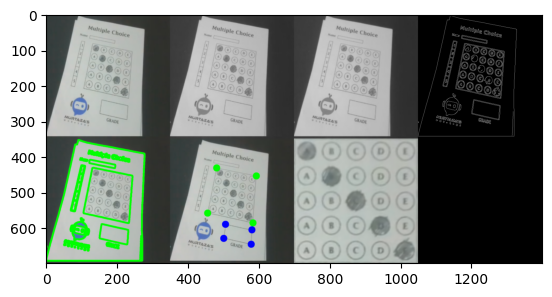

In [21]:
#Display
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgWarpColored,imgBlank])
imgStacked = stackImages(imageArray, 0.5)
plt.imshow(imgStacked)

#### Warping the Grade Box

In [22]:
pt3 = np.float32(gradePoints)
pt4 = np.float32([[0,0],[325,0],[0,150], [325,150]])
matrixG = cv2.getPerspectiveTransform(pt3,pt4)
imgWarpColoredGP = cv2.warpPerspective(img,matrixG,(325,150))

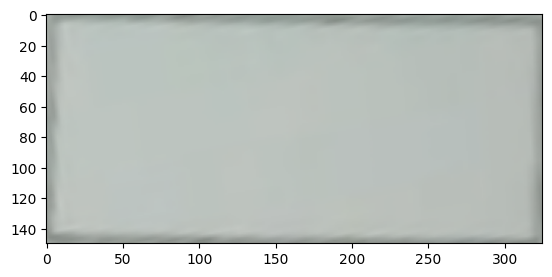

In [23]:
plt.imshow(imgWarpColoredGP)

#### Apply Thresholding to find the markings

In [24]:
imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)  #Convert to grayscale
imgThresh = cv2.threshold(imgWarpGray, 170,255,cv2.THRESH_BINARY_INV)[1]  # Apply binary thresholding

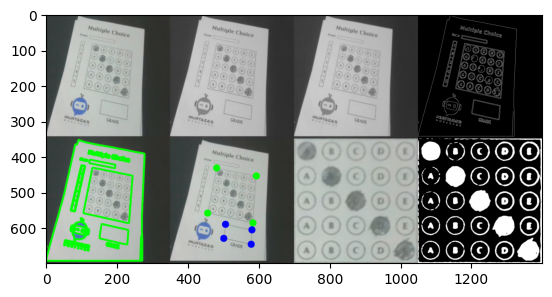

In [25]:
#Display
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgWarpColored,imgThresh])
imgStacked = stackImages(imageArray, 0.5)
plt.imshow(imgStacked)

### Splitting the thresholded OMR into individual answer boxes

##### To Find the individual bubbles(options) to check which is marked and not marked, we have to split the options row wise and column wise

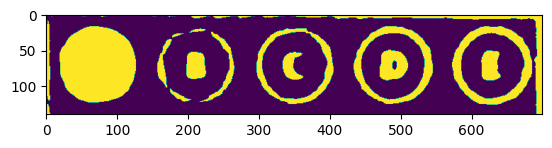

In [26]:
rows = np.vsplit(imgThresh,5)
plt.imshow(rows[0])

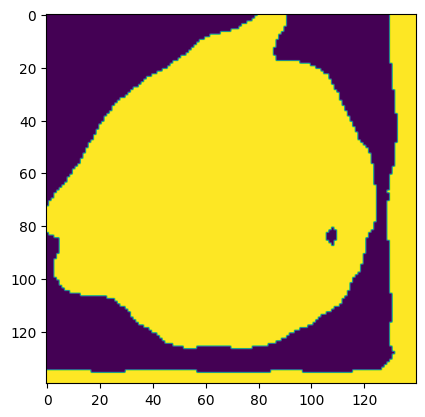

In [27]:
boxes = []
for r in rows:
    cols = np.hsplit(r,5)
    for box in cols:
        boxes.append(box)
        plt.imshow(box)
## prints the lastmost bubble of the image

In [28]:
# Splitting the thresholded OMR into individual answer boxes
def splitBoxes(img):
    rows = np.vsplit(img,questions)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,choices)
        for box in cols:
            boxes.append(box)
    return boxes

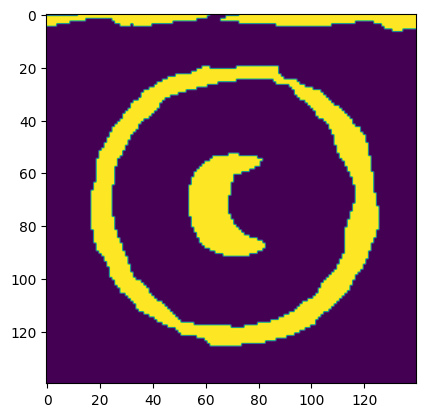

In [29]:
boxes = splitBoxes(imgThresh)
plt.imshow(boxes[2])  # Show an example box for debugging

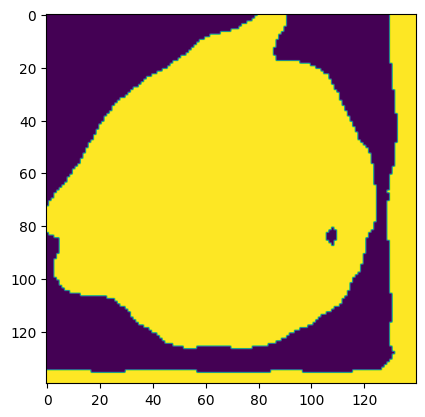

In [30]:
plt.imshow(boxes[24]) # Show an example box for debugging

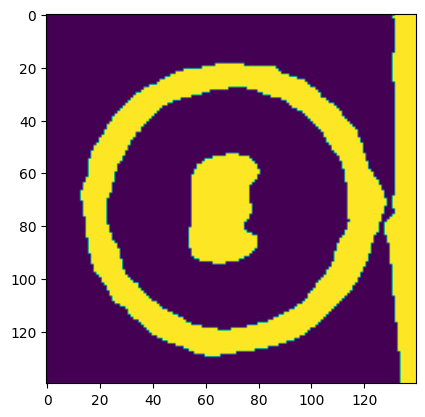

In [31]:
plt.imshow(boxes[9])  # Show an example box for debugging

#### To check if a bubble is marked or not, we check the number of non-zero pixels present in each of the 25 boxes. if it is more than threshold, it is marked option

In [32]:
print(cv2.countNonZero(boxes[1]), cv2.countNonZero(boxes[2])) #box[1] is marked but box[2] isn't

2876 3561


###  User Answer Detection

In [33]:
#iterate through each of the box to get total no. of pixels in each box
pixelPerBubble = np.zeros((questions,choices))
countC = 0
countR = 0
for image in boxes:
    totalPixels = cv2.countNonZero(image)
    pixelPerBubble[countR][countC] = totalPixels
    countC += 1
    if(countC == choices):
        countR += 1
        countC = 0
print(pixelPerBubble)

[[10010.  2876.  3561.  5054.  6486.]
 [ 2157. 10223.  2810.  4090.  5377.]
 [ 2515.  2814. 10596.  4307.  5441.]
 [ 3155.  2949.  3122. 10706.  5386.]
 [ 3792.  3847.  3986.  4638. 12857.]]


In [34]:
# Convert pixelPerBubble into a matrix of for simplification by finding the maximum sum per row
# FINDING INDEX VALUE OF THE MARKINGS
myIndex = []
for x in range(0,questions):
    arr = pixelPerBubble[x]
    myIndexVal = np.where(arr==np.amax(arr))
    myIndex.append(myIndexVal[0][0])
print(myIndex)
    


[0, 1, 2, 3, 4]


###  Grading the Answers

In [35]:
grading = []
for x in range(0, questions):
    if ans[x] == myIndex[x]:
        grading.append(1)
    else:
        grading.append(0)
print(grading)
    

[0, 0, 0, 0, 0]


#### Final Score

In [36]:
score = (sum(grading)/questions) * 100
print(score)

0.0


### Displaying answers

In [37]:
def showAns(img,myIndex,grading,ans,questions,choices):
    secW = int(img.shape[1]/questions)
    secH = int(img.shape[0]/choices)
    
    for x in range(0,questions):
        myAns = myIndex[x]
        cX = (myAns*secW)+secW//2
        cY = (x*secH)+secH//2
        if(grading[x]==1):
            myColor = (0,255,0) #green correct
        else:
            myColor = (255,0,0)#red incorrect
            correctAns = ans[x]
            aX = (correctAns*secW)+secW//2            
            cv2.circle(img,(aX,cY),20,(0,255,0),cv2.FILLED)
            
        cv2.circle(img,(cX,cY),50,myColor,cv2.FILLED)
    return img       
    
    

In [38]:
imgResult = imgWarpColored.copy()
showAns(imgResult,myIndex,grading,ans,questions,choices)

array([[[179, 185, 179],
        [178, 184, 178],
        [176, 182, 176],
        ...,
        [161, 167, 161],
        [163, 169, 163],
        [165, 171, 165]],

       [[177, 183, 177],
        [176, 182, 176],
        [174, 180, 174],
        ...,
        [159, 165, 159],
        [161, 167, 161],
        [163, 169, 163]],

       [[175, 181, 176],
        [173, 179, 174],
        [172, 178, 173],
        ...,
        [157, 163, 157],
        [159, 165, 160],
        [162, 168, 162]],

       ...,

       [[158, 164, 159],
        [152, 158, 153],
        [147, 153, 148],
        ...,
        [151, 157, 152],
        [155, 161, 156],
        [159, 165, 160]],

       [[161, 167, 162],
        [157, 163, 158],
        [153, 159, 154],
        ...,
        [150, 156, 151],
        [154, 160, 155],
        [159, 165, 160]],

       [[168, 174, 169],
        [164, 170, 165],
        [160, 166, 161],
        ...,
        [152, 158, 153],
        [157, 163, 157],
        [161, 167, 162]]

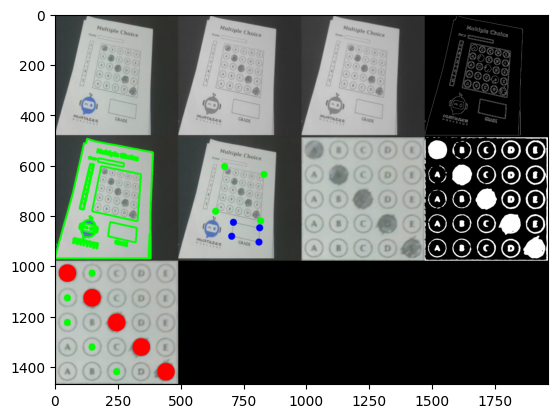

In [39]:
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgWarpColored,imgThresh],
             [imgResult,imgBlank,imgBlank,imgBlank])
imgStacked = stackImages(imageArray, 0.7)
plt.imshow(imgStacked)

###  Create an inverse warp to project the answers back onto the original image

In [40]:
imRawDrawing = np.zeros_like(imgWarpColored)
imRawDrawing = showAns(imRawDrawing,myIndex,grading,ans,questions,choices)

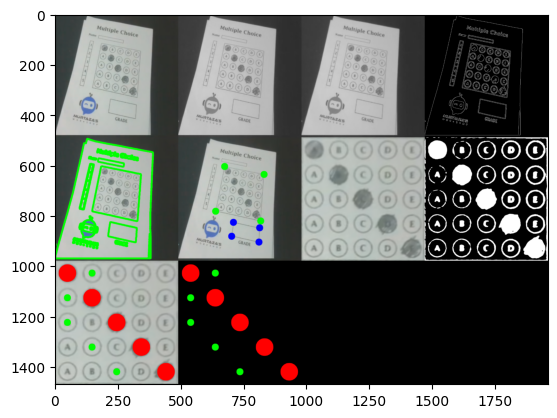

In [41]:
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgWarpColored,imgThresh],
             [imgResult,imRawDrawing,imgBlank,imgBlank])
imgStacked = stackImages(imageArray, 0.7)
plt.imshow(imgStacked)

In [42]:
invMatrix = cv2.getPerspectiveTransform(pt2,pt1)
invImgWarp = cv2.warpPerspective(imRawDrawing,invMatrix,(widthImg,heightImg))

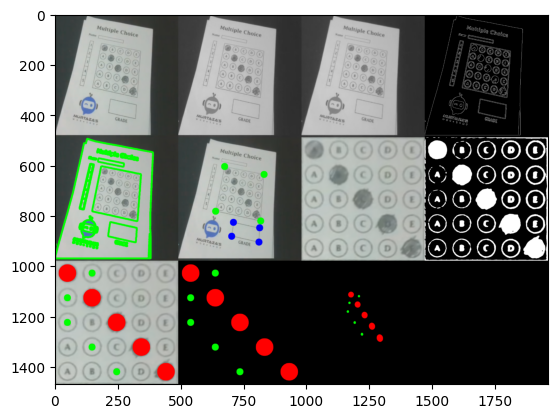

In [43]:
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgWarpColored,imgThresh],
             [imgResult,imRawDrawing,invImgWarp,imgBlank])
imgStacked = stackImages(imageArray, 0.7)
plt.imshow(imgStacked)

###   Merge answers and grade with the final image

In [44]:
imgFinal = cv2.addWeighted(imgFinal,1,invImgWarp,1,0)

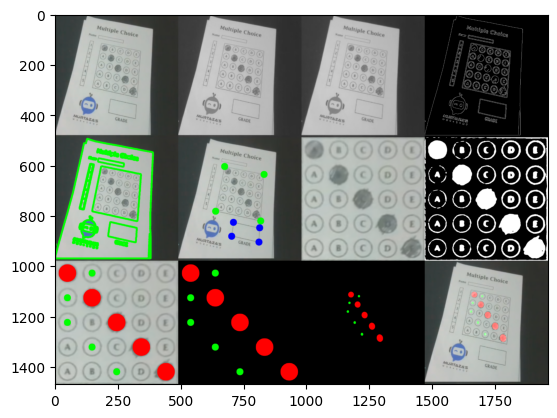

In [45]:
#Display
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgWarpColored,imgThresh],
             [imgResult,imRawDrawing,invImgWarp,imgFinal])
imgStacked = stackImages(imageArray, 0.7)
plt.imshow(imgStacked)

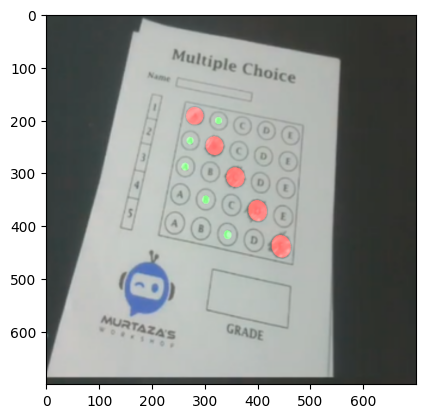

In [46]:
plt.imshow(imgFinal)

### To Display grade on the grade box

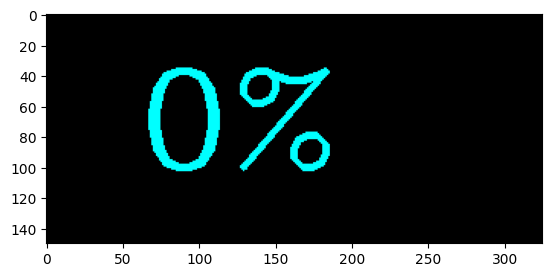

In [47]:
imgRawGrade = np.zeros_like(imgWarpColoredGP, np.uint8)
cv2.putText(imgRawGrade, str(int(score))+"%", (60,100), cv2.FONT_HERSHEY_COMPLEX,3,(0,255,255),3)
plt.imshow(imgRawGrade)

#### Do the inverse perspective of grade and place it upon the original image

In [48]:
invMatrixG = cv2.getPerspectiveTransform(pt4,pt3)
invImgWarpG = cv2.warpPerspective(imgRawGrade,invMatrixG,(widthImg,heightImg))

### Merge answers and grade with the final image


In [49]:
imgFinal = cv2.addWeighted(imgFinal,1,invImgWarpG,1,0)

### Final Results Display

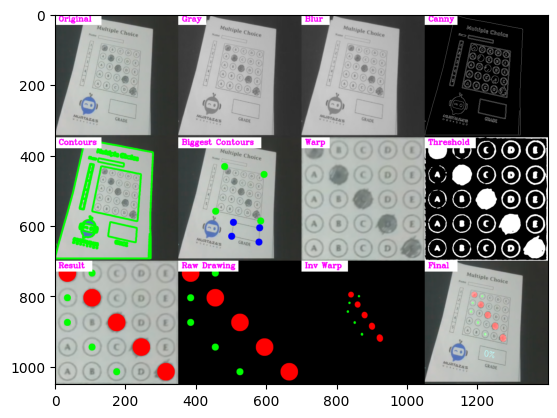

In [50]:
imageArray = ([img, imgGray, imgBlur,imgCanny],
             [imgContours,imgKeyContours,imgWarpColored,imgThresh],
             [imgResult,imRawDrawing,invImgWarp,imgFinal])
labels = [["Original", "Gray", "Blur","Canny"],
          ["Contours","Biggest Contours","Warp","Threshold"],
          ["Result","Raw Drawing", "Inv Warp", "Final"]]
          
imgStacked = stackImages(imageArray,0.5,labels)
plt.imshow(imgStacked)

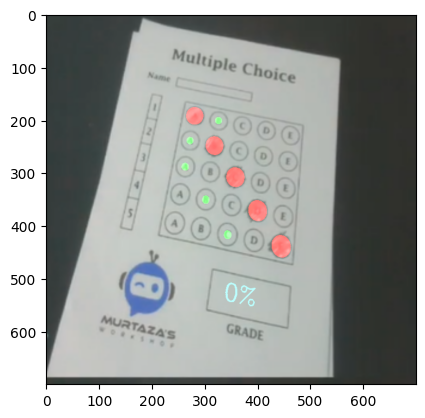

In [51]:
plt.imshow(imgFinal)

In [52]:
#cv2.imshow("Original", img)
#cv2.waitKey(0)